# Explore Training Curves

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6.5,5)

In [10]:
def find_baseline_moving_avg(file_list, window_size):  
    if len(file_list) == 1:
        df=pd.read_csv(file_list[0], sep = ',', skiprows = 0, header = 0)
        data = df['r']
        quantile1 = np.zeros(len(data)-window_size)
        quantile2 = np.zeros(len(data)-window_size)
        avg = np.zeros(len(data)-window_size)
        for i in range(len(data)-window_size):
            avg[i] = np.mean(data[i:i+window_size])
            quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
            quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
        return avg, quantile1, quantile2
    else:
        # find minimum length
        min_len = 1e7
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep = ',', skiprows = 0, header = 0)
            y_val = df['r']
            cur_len = len(y_val)
            if cur_len < min_len:
                min_len = cur_len
        data = np.zeros((len(file_list), min_len))
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep = ',', skiprows = 0, header = 0)
            data[i,:] = df['r'].values.ravel()[0:min_len]
        std = np.std(data,axis=0)
        avg = np.mean(data,axis=0)
        smoothed_avg = np.zeros(min_len-window_size)
        smoothed_std = np.zeros(min_len-window_size)
        # smooth 
        for i in range(min_len-window_size):
            smoothed_avg[i] = np.mean(avg[i:i+window_size])
            smoothed_std[i] = np.mean(std[i:i+window_size])
        return smoothed_avg, smoothed_avg-smoothed_std, smoothed_avg+smoothed_std

# Baseline 

Text(0,0.5,'Average Return')

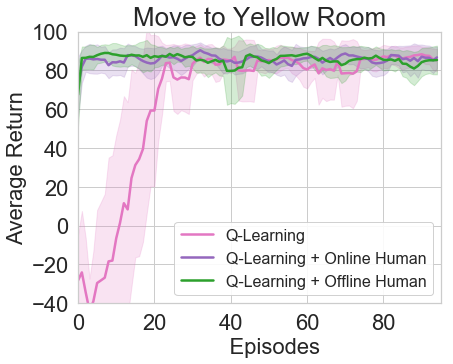

In [11]:
q_learning_log_name = ['./log_files/GridWorld-q-learning/1610621904.212886.csv', './log_files/GridWorld-q-learning/1610621963.719276.csv', 
                       './log_files/GridWorld-q-learning/1610622971.841064.csv', './log_files/GridWorld-q-learning/1610623929.645105.csv',
                       './log_files/GridWorld-q-learning/1610624213.111349.csv']
q_learning_off_human_log_name = ['./log_files/GridWorld-q-learning-offline-human/1610621943.9203851.csv', './log_files/GridWorld-q-learning-offline-human/1610621957.896211.csv',
                             './log_files/GridWorld-q-learning-offline-human/1610622976.264647.csv', './log_files/GridWorld-q-learning-offline-human/1610623933.438024.csv',
                             './log_files/GridWorld-q-learning-offline-human/1610624216.214272.csv']
q_learning_on_human_log_name = ['./log_files/GridWorld-q-learning-online-human/1612072078.769877.csv', './log_files/GridWorld-q-learning-online-human/1612075793.829283.csv',
                               './log_files/GridWorld-q-learning-online-human/1612075813.577657.csv', './log_files/GridWorld-q-learning-online-human/1612076020.041473.csv',
                               './log_files/GridWorld-q-learning-online-human/1612076024.8116548.csv']

window_size = 5
moving_average = find_baseline_moving_avg(q_learning_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='Q-Learning', linewidth = 2.5, color = 'tab:pink')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:pink')

moving_average = find_baseline_moving_avg(q_learning_on_human_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='Q-Learning + Online Human', linewidth = 2.5, color = 'tab:purple')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:purple')

moving_average = find_baseline_moving_avg(q_learning_off_human_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='Q-Learning + Offline Human', linewidth = 2.5, color = 'tab:green')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:green')

plt.title('Move to Yellow Room', fontsize = 26)
plt.rcParams["legend.framealpha"] = 0.9
plt.legend(fontsize=16, loc='lower right')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim([-40, 100])
plt.xlim([0, 95])
plt.xlabel('            Episodes       ', fontsize=22)
plt.ylabel('Average Return',fontsize=22)

Text(0,0.5,'Average Return')

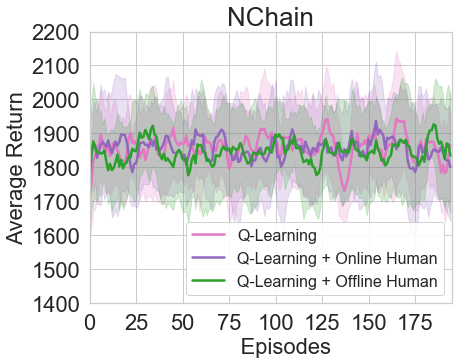

In [38]:
q_learning_log_name = ['./log_files/NChain-q-learning/1610625443.2615628.csv', './log_files/NChain-q-learning/1610625728.697116.csv',
                       './log_files/NChain-q-learning/1610626562.486154.csv', './log_files/NChain-q-learning/1610627567.098939.csv', 
                       './log_files/NChain-q-learning/1610627576.3587651.csv']
q_learning_off_human_log_name = ['./log_files/NChain-q-learning-offline-human/1610625684.7983181.csv', './log_files/NChain-q-learning-offline-human/1610625739.958105.csv',
                             './log_files/NChain-q-learning-offline-human/1610626550.080721.csv', './log_files/NChain-q-learning-offline-human/1610627547.208122.csv',
                             './log_files/NChain-q-learning-offline-human/1610627558.5284271.csv']
q_learning_on_human_log_name = ['./log_files/NChain-q-learning-online-human/1612073903.427412.csv', './log_files/NChain-q-learning-online-human/1612075804.433493.csv',
                               './log_files/NChain-q-learning-online-human/1612075939.2037911.csv', './log_files/NChain-q-learning-online-human/1612076010.926225.csv',
                               './log_files/NChain-q-learning-online-human/1612076031.9520829.csv']

window_size = 5
moving_average = find_baseline_moving_avg(q_learning_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='Q-Learning', linewidth = 2.5, color = 'tab:pink')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:pink')

moving_average = find_baseline_moving_avg(q_learning_on_human_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='Q-Learning + Online Human', linewidth = 2.5, color = 'tab:purple')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:purple')

moving_average = find_baseline_moving_avg(q_learning_off_human_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='Q-Learning + Offline Human', linewidth = 2.5, color = 'tab:green')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:green')


plt.title('NChain', fontsize = 26)
plt.rcParams["legend.framealpha"] = 0.9
plt.legend(fontsize=16, loc='lower right')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim([1400, 2200])
plt.xlim([0, 195])
plt.xlabel('            Episodes       ', fontsize=22)
plt.ylabel('Average Return',fontsize=22)

# ODRPO

Text(0,0.5,'Average Return')

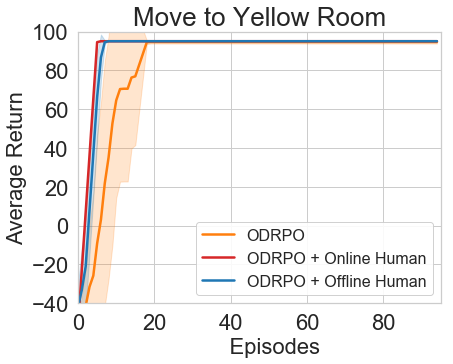

In [12]:
odrpo_log_name = ['./log_files/GridWorld-odrpo/1612073548.2660868.csv', './log_files/GridWorld-odrpo/1612073569.752167.csv',
                 './log_files/GridWorld-odrpo/1612077341.3391092.csv', './log_files/GridWorld-odrpo/1612077361.7814531.csv',
                 './log_files/GridWorld-odrpo/1612077503.42831.csv']
odrpo_off_human_log_name = ['./log_files/GridWorld-odrpo-offline-human/1612074270.061528.csv', './log_files/GridWorld-odrpo-offline-human/1612076991.9430022.csv',
                           './log_files/GridWorld-odrpo-offline-human/1612076994.643244.csv', './log_files/GridWorld-odrpo-offline-human/1612077157.89425.csv',
                           './log_files/GridWorld-odrpo-offline-human/1612077159.420602.csv']
odrpo_on_human_log_name = ['./log_files/GridWorld-odrpo-online-human/1612073099.363196.csv', './log_files/GridWorld-odrpo-online-human/1612073270.509902.csv',
                          './log_files/GridWorld-odrpo-online-human/1612073446.5688782.csv', './log_files/GridWorld-odrpo-online-human/1612076988.781975.csv',
                          './log_files/GridWorld-odrpo-online-human/1612076998.407163.csv']


window_size = 5
moving_average = find_baseline_moving_avg(odrpo_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='ODRPO', linewidth = 2.5, color = 'tab:orange')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:orange')

moving_average = find_baseline_moving_avg(odrpo_off_human_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='ODRPO + Online Human', linewidth = 2.5, color = 'tab:red')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:red')

moving_average = find_baseline_moving_avg(odrpo_on_human_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='ODRPO + Offline Human', linewidth = 2.5, color = 'tab:blue')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:blue')

plt.title('Move to Yellow Room', fontsize = 26)
plt.rcParams["legend.framealpha"] = 0.9
plt.legend(fontsize=16, loc='lower right')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim([-40, 100])
plt.xlim([0, 95])
plt.xlabel('            Episodes       ', fontsize=22)
plt.ylabel('Average Return',fontsize=22)

Text(0,0.5,'Average Return')

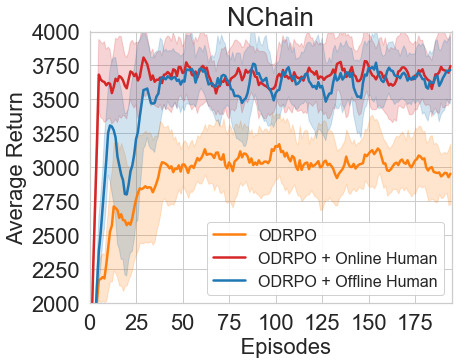

In [14]:
odrpo_log_name = ['./log_files/NChain-odrpo/1612075333.6526248.csv', './log_files/NChain-odrpo/1612075470.3066628.csv',
                 './log_files/NChain-odrpo/1612076355.8013911.csv', './log_files/NChain-odrpo/1612076735.1794739.csv', 
                 './log_files/NChain-odrpo/1612076563.855464.csv']
odrpo_off_human_log_name = ['./log_files/NChain-odrpo-offline-human/1612075123.2715158.csv', './log_files/NChain-odrpo-offline-human/1612075531.178696.csv',
                           './log_files/NChain-odrpo-offline-human/1612075576.6531699.csv', './log_files/NChain-odrpo-offline-human/1612076827.885691.csv',
                           './log_files/NChain-odrpo-offline-human/1612076871.5853498.csv']
odrpo_on_human_log_name = ['./log_files/NChain-odrpo-online-human/1612220962.9383922.csv', './log_files/NChain-odrpo-online-human/1612221056.925476.csv',
                          './log_files/NChain-odrpo-online-human/1612075591.672075.csv', './log_files/NChain-odrpo-online-human/1612076788.685479.csv',
                          './log_files/NChain-odrpo-online-human/1612076921.46519.csv']

window_size = 5
moving_average = find_baseline_moving_avg(odrpo_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='ODRPO', linewidth = 2.5, color = 'tab:orange')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:orange')

moving_average = find_baseline_moving_avg(odrpo_on_human_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='ODRPO + Online Human', linewidth = 2.5, color = 'tab:red')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:red')

moving_average = find_baseline_moving_avg(odrpo_off_human_log_name, window_size)
plt.plot(np.arange(len(moving_average[0])), moving_average[0], label='ODRPO + Offline Human', linewidth = 2.5, color = 'tab:blue')
plt.fill_between(np.arange(len(moving_average[0])), moving_average[1], moving_average[2], alpha=0.2, color = 'tab:blue')


plt.title('NChain', fontsize = 26)
plt.rcParams["legend.framealpha"] = 0.9
plt.legend(fontsize=16, loc='lower right')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim([2000, 4000])
plt.xlim([0, 195])
plt.xlabel('            Episodes       ', fontsize=22)
plt.ylabel('Average Return',fontsize=22)